# Import Libraries and Data

## Basics

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from copy import deepcopy

## Preprocessing

In [3]:
from scipy.stats import iqr
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.feature_selection import SelectKBest, chi2, RFECV
from sklearn.decomposition import PCA

## Algorithms

In [4]:
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
import mord as m

## Evaluation

In [5]:
from sklearn.model_selection import StratifiedKFold, cross_val_predict, LeaveOneOut, train_test_split, KFold, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, log_loss, recall_score
from sklearn.utils.multiclass import unique_labels
import graphviz
from scipy.stats import chi2_contingency

def confusion_matrix_report(y_true, y_pred):    
    cm, labels = confusion_matrix(y_true, y_pred), unique_labels(y_true, y_pred)
    column_width = max([len(str(x)) for x in labels] + [5])  # 5 is value length
    report = " " * column_width + " " + "{:_^{}}".format("Prediction", column_width * len(labels))+ "\n"
    report += " " * column_width + " ".join(["{:>{}}".format(label, column_width) for label in labels]) + "\n"
    for i, label1 in enumerate(labels):
        report += "{:>{}}".format(label1, column_width) + " ".join(["{:{}d}".format(cm[i, j], column_width) for j in range(len(labels))]) + "\n"
    return report

## Data

In [6]:
red = pd.read_csv("./data/winequality-red1.csv")
white = pd.read_csv("./data/winequality-white1.csv")

# Data Manipulation and Preprocessing

In [7]:
red_data = deepcopy(red)
white_data = deepcopy(white)

conditions_red = [(red_data['quality'] <= 5),
              (red_data['quality'] >= 7)]
conditions_white = [(white_data['quality'] <= 5),
              (white_data['quality'] >= 7)]

choices = ['1 - low', '3 - high']

red_data['quality class'] = np.select(conditions_red, choices, default = '2 - middle')
white_data['quality class'] = np.select(conditions_white, choices, default = '2 - middle')

In [8]:
red_data.pop("quality")
red_label = red_data.pop("quality class")

white_data.pop("quality")
white_label = white_data.pop("quality class")

In [9]:
red["citric acid"].describe()

count    1599.000000
mean        0.270976
std         0.194801
min         0.000000
25%         0.090000
50%         0.260000
75%         0.420000
max         1.000000
Name: citric acid, dtype: float64

In [10]:
### Removing outliers ###

# Classification

## Naive Bayes Classifier

In [11]:
model_bayes = GaussianNB()

prediction_bayes = cross_val_predict(model_bayes, red_data, red_label, cv=10)

## Improving Power of NB

In [12]:
### Transform data to get a normal distribution via logarithm ###

red_data_log = np.log(red_data[["fixed acidity", "volatile acidity", "residual sugar", "chlorides", "free sulfur dioxide", "total sulfur dioxide", "density", "pH", "sulphates", "alcohol"]])
red_data_log["citric acid"] = red_data["citric acid"]

prediction_bayes_log = cross_val_predict(model_bayes, red_data_log, red_label, cv=10)

In [48]:
### Remove highly correlated variables ###
red_data_corrout = deepcopy(red_data)
red_data_corrout.pop("free sulfur dioxide") #Higly correlated with total sulfur dioxide, but little correlation with alcohol
red_data_corrout.pop("pH")
#red_data_corrout.pop("density") # Highly correlated with alcohol
red_data_corrout.pop("citric acid") # Highly correlated with fixed acidity, volatile acidity and pH, but little correlation with alcohol
red_data_corrout.pop("fixed acidity") # Highly correlated with density and citric acid, but little correlation with alcohol
red_data_corrout.pop("residual sugar")
red_data_corrout.pop("chlorides")
#red_data_corrout.pop("total sulfur dioxide")
#red_data_corrout.pop("sulphates")
#red_data_corrout.pop("volatile acidity")
prediction_bayes_corrout = cross_val_predict(model_bayes, red_data_corrout, red_label, cv=10)

### Automatic feature selection 
https://machinelearningmastery.com/feature-selection-machine-learning-python/

In [14]:
### Univariate selection ###

selection = SelectKBest(score_func=chi2, k=5)
fit = selection.fit(red_data, red_label)

np.set_printoptions(precision=3)
#print(fit.scores_)
features = pd.DataFrame(fit.transform(red_data))
# summarize selected features
#print(features)
prediction = cross_val_predict(model_bayes, features, red_label, cv=10)
print(classification_report(red_label, prediction))


             precision    recall  f1-score   support

    1 - low       0.69      0.73      0.71       744
 2 - middle       0.53      0.51      0.52       638
   3 - high       0.50      0.46      0.48       217

avg / total       0.60      0.61      0.60      1599



In [23]:
### Univariate selection + log ###

selection = SelectKBest(score_func=chi2, k=5)
fit = selection.fit(red_data, red_label)

np.set_printoptions(precision=3)
#print(fit.scores_)
features = pd.DataFrame(fit.transform(red_data))
# summarize selected features
#print(features)
prediction = cross_val_predict(model_bayes, features, red_label, cv=10)
print(classification_report(red_label, prediction))


             precision    recall  f1-score   support

    1 - low       0.61      0.74      0.67       744
 2 - middle       0.49      0.42      0.45       638
   3 - high       0.42      0.28      0.34       217

avg / total       0.54      0.55      0.54      1599



In [16]:
#sns.heatmap(red_data_corrout.corr(),cmap='coolwarm',annot=True)

In [17]:
### Combine logarithm and removal of correlated variables

red_data_corrout_log = np.log(red_data_corrout[["volatile acidity", "residual sugar", "chlorides", "total sulfur dioxide", "pH", "sulphates", "alcohol"]])

prediction_bayes_corrout_log = cross_val_predict(model_bayes, red_data_corrout_log, red_label, cv=10)

In [18]:
### Normalisation ### 
red_data_normalised = pd.DataFrame(
    preprocessing.MinMaxScaler().fit_transform(red_data),
    columns=["fixed acidity", "volatile acidity", "citric acid", "residual sugar", "chlorides", "free sulfur dioxide", "total sulfur dioxide", "density", "pH", "sulphates", "alcohol"
]
)

prediction_bayes_normalised = cross_val_predict(model_bayes, red_data_normalised, red_label, cv=10)

In [19]:
### Standardisation ###
scaler = StandardScaler()  
scaler.fit(red_data)

red_data_standardised = pd.DataFrame(scaler.transform(red_data))  

prediction_bayes_standardised = cross_val_predict(model_bayes, red_data_standardised, red_label, cv=10)
#print(classification_report(red_label, prediction_bayes_standardised))

In [20]:
### PCA ###

pca = PCA()
red_data_pca = pca.fit_transform(red_data)

prediction_bayes_pca = cross_val_predict(model_bayes, red_data_pca, red_label, cv=10)

#print(classification_report(red_label, prediction_bayes_pca))

In [21]:
### Box-Cox-Transformation ###

## Comparison

In [49]:
print("Naive Bayes (default):")
print(confusion_matrix_report(red_label, prediction_bayes))
print(accuracy_score(red_label, prediction_bayes))
print(classification_report(red_label, prediction_bayes))
print("-------------------------------------------------------------------------")
print("Naive Bayes (logarithm):")
print(confusion_matrix_report(red_label, prediction_bayes_log))
print(accuracy_score(red_label, prediction_bayes_log))
print(classification_report(red_label, prediction_bayes_log))
print("-------------------------------------------------------------------------")
print("Naive Bayes (without highly correlated variables):")
print(confusion_matrix_report(red_label, prediction_bayes_corrout))
print(accuracy_score(red_label, prediction_bayes_corrout))
print(classification_report(red_label, prediction_bayes_corrout))
print("-------------------------------------------------------------------------")
print("Naive Bayes (without highly correlated variables and logarithm):")
print(confusion_matrix_report(red_label, prediction_bayes_corrout_log))
print(accuracy_score(red_label, prediction_bayes_corrout_log))
print(classification_report(red_label, prediction_bayes_corrout_log))
print("-------------------------------------------------------------------------")
print("Naive Bayes (normalised data):")
print(confusion_matrix_report(red_label, prediction_bayes_normalised))
print(accuracy_score(red_label, prediction_bayes_normalised))
print(classification_report(red_label, prediction_bayes_normalised))
print("-------------------------------------------------------------------------")
print("Naive Bayes (standardised data):")
print(confusion_matrix_report(red_label, prediction_bayes_standardised))
print(accuracy_score(red_label, prediction_bayes_standardised))
print(classification_report(red_label, prediction_bayes_standardised))




Naive Bayes (default):
           __________Prediction__________
             1 - low 2 - middle   3 - high
   1 - low       515        202         27
2 - middle       212        303        123
  3 - high        12         85        120

0.5866166353971232
             precision    recall  f1-score   support

    1 - low       0.70      0.69      0.69       744
 2 - middle       0.51      0.47      0.49       638
   3 - high       0.44      0.55      0.49       217

avg / total       0.59      0.59      0.59      1599

-------------------------------------------------------------------------
Naive Bayes (logarithm):
           __________Prediction__________
             1 - low 2 - middle   3 - high
   1 - low       587        130         27
2 - middle       267        266        105
  3 - high        21         75        121

0.6091307066916823
             precision    recall  f1-score   support

    1 - low       0.67      0.79      0.73       744
 2 - middle       0.56      0.42   

## Random Forest Classifier

In [227]:
model_rfc = RandomForestClassifier(n_estimators=25, random_state=12)

prediction_rfc = cross_val_predict(model_rfc, red_data_standardised, red_label, cv=10)

print("Random Forest:")
print(confusion_matrix_report(red_label, prediction_rfc))
print(accuracy_score(red_label, prediction_rfc))
print(classification_report(red_label, prediction_rfc))

Random Forest:
           __________Prediction__________
             1 - low 2 - middle   3 - high
   1 - low       528        207          9
2 - middle       256        330         52
  3 - high        18        130         69

0.5797373358348968
             precision    recall  f1-score   support

    1 - low       0.66      0.71      0.68       744
 2 - middle       0.49      0.52      0.51       638
   3 - high       0.53      0.32      0.40       217

avg / total       0.58      0.58      0.57      1599



In [41]:
# Import a supervised learning model that has 'feature_importances_'
model = RandomForestClassifier(max_depth=None, random_state=None)
# Train the supervised model on the training set using .fit(X_train, y_train)
model = model.fit(red_data, red_label)
# Extract the feature importances using .feature_importances_ 
importances = model.feature_importances_
print(red_data.columns)
print(importances)
# Plot

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol'],
      dtype='object')
[0.078 0.108 0.069 0.069 0.08  0.066 0.094 0.091 0.074 0.114 0.157]


Feature ranking:
1. feature 10 (0.157352)
2. feature 9 (0.114213)
3. feature 1 (0.108305)
4. feature 6 (0.093736)
5. feature 7 (0.091070)
6. feature 4 (0.080185)
7. feature 0 (0.077919)
8. feature 8 (0.073789)
9. feature 3 (0.068803)
10. feature 2 (0.068754)
11. feature 5 (0.065873)


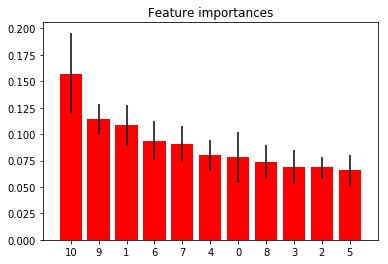

In [44]:
std = np.std([tree.feature_importances_ for tree in model.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(red_data.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(red_data.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(red_data.shape[1]), indices)
plt.xlim([-1, red_data.shape[1]])
plt.show()

In [45]:
red_data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4


In [234]:
import mord as m

### Outlier detection

In [74]:
red_out = deepcopy(red)
#q1 = red_out["alcohol"].quantile(0.25)
#q3 = red_out["alcohol"].quantile(0.75)
#iqr = q3 - q1
column = ["fixed acidity", "volatile acidity", "citric acid", "residual sugar", "chlorides", "free sulfur dioxide", "total sulfur dioxide", "density", "pH", "sulphates", "alcohol"]

In [89]:
def get_subset_by_IQR(df,column):
    q1 = column.quantile(0.25)
    q3 = column.quantile(0.75)
    iqr = q3 - q1 
    outliers = (column >= (1.5*iqr)) & (column <= 1.5*iqr)
    return df.loc[outliers]

In [90]:
red_out_new = get_subset_by_IQR(red_out, red_out["alcohol"])

In [91]:
red_out_new.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [79]:
def remove_outliers_iqr(i, column):
    q1 = column.quantile(0.25)
    q3 = column.quantile(0.75)
    iqr = q3 - q1
    low_border = q1 - 1.5 * iqr
    high_border = q3 + 1.5 * iqr
    outlier = data.loc[(data[column] > low_border) & (data[column] < high_border)]
    return outlier

In [80]:
print(boston_df_o1 < (Q1 - 1.5 * IQR)) |(boston_df_o1 > (Q3 + 1.5 * IQR))

ValueError: Cannot index with multidimensional key

In [59]:
attributes = ["fixed acidity", "volatile acidity", "citric acid", "residual sugar", "chlorides", "free sulfur dioxide", "total sulfur dioxide", "density", "pH", "sulphates", "alcohol"]
count = 0
for i in red_out["alcohol"]:
    if i > 1.5*(red_out["alcohol"].quantile(0.75) - (red_out["alcohol"].quantile(0.25))):
        i == 1

In [60]:
red_out["alcohol"].describe()

count    1599.000000
mean       10.422983
std         1.065668
min         8.400000
25%         9.500000
50%        10.200000
75%        11.100000
max        14.900000
Name: alcohol, dtype: float64

## Different Classifiers

In [237]:
classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="rbf", C=0.025, probability=True),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis()]


# Logging for Visual Comparison
log_cols=["Classifier", "Accuracy", "Log Loss"]
log = pd.DataFrame(columns=log_cols)

for clf in classifiers:
    prediction_val = cross_val_predict(clf, red_data, red_label, cv=10)
    name = clf.__class__.__name__

    
    print("="*30)
    print(name)
    
    print('****Results****')
    acc = accuracy_score(red_label, prediction_val)
    print("Accuracy: {:.4%}".format(acc))
    print(classification_report(red_label, prediction_val))

KNeighborsClassifier
****Results****
Accuracy: 49.2183%
             precision    recall  f1-score   support

    1 - low       0.55      0.61      0.58       744
 2 - middle       0.43      0.41      0.42       638
   3 - high       0.44      0.31      0.36       217

avg / total       0.49      0.49      0.49      1599

SVC
****Results****
Accuracy: 46.5291%
             precision    recall  f1-score   support

    1 - low       0.47      1.00      0.64       744
 2 - middle       0.00      0.00      0.00       638
   3 - high       0.00      0.00      0.00       217

avg / total       0.22      0.47      0.30      1599

DecisionTreeClassifier
****Results****
Accuracy: 51.6573%
             precision    recall  f1-score   support

    1 - low       0.61      0.63      0.62       744
 2 - middle       0.44      0.43      0.43       638
   3 - high       0.41      0.39      0.40       217

avg / total       0.51      0.52      0.51      1599



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


RandomForestClassifier
****Results****
Accuracy: 58.2239%
             precision    recall  f1-score   support

    1 - low       0.64      0.75      0.69       744
 2 - middle       0.52      0.47      0.49       638
   3 - high       0.51      0.35      0.42       217

avg / total       0.57      0.58      0.57      1599

AdaBoostClassifier
****Results****
Accuracy: 60.5378%
             precision    recall  f1-score   support

    1 - low       0.68      0.75      0.71       744
 2 - middle       0.54      0.51      0.53       638
   3 - high       0.50      0.37      0.43       217

avg / total       0.60      0.61      0.60      1599

GradientBoostingClassifier
****Results****
Accuracy: 61.2883%
             precision    recall  f1-score   support

    1 - low       0.69      0.74      0.72       744
 2 - middle       0.54      0.54      0.54       638
   3 - high       0.53      0.40      0.45       217

avg / total       0.61      0.61      0.61      1599

GaussianNB
****Results

# Theory

## Naive Bayes Classifier

https://www.analyticsvidhya.com/blog/2017/09/naive-bayes-explained/:

Pros:

- It is easy and fast to predict class of test data set. It also perform well in multi class prediction
- When assumption of independence holds, a Naive Bayes classifier performs better compare to other models like logistic regression and you need less training data.
- It perform well in case of categorical input variables compared to numerical variable(s). For numerical variable, normal distribution is assumed (bell curve, which is a strong assumption).

Cons:

- If categorical variable has a category (in test data set), which was not observed in training data set, then model will assign a 0 (zero) probability and will be unable to make a prediction. This is often known as “Zero Frequency”. To solve this, we can use the smoothing technique. One of the simplest smoothing techniques is called Laplace estimation.
- On the other side naive Bayes is also known as a bad estimator, so the probability outputs from predict_proba are not to be taken too seriously.
- Another limitation of Naive Bayes is the assumption of independent predictors. In real life, it is almost impossible that we get a set of predictors which are completely independent.
 

### Trying to improve the power of Naive Bayes

https://www.analyticsvidhya.com/blog/2017/09/naive-bayes-explained/:

- If continuous features do not have normal distribution, we should use transformation or different methods to convert it in normal distribution.
- If test data set has zero frequency issue, apply smoothing techniques “Laplace Correction” to predict the class of test data set.
- Remove correlated features, as the highly correlated features are voted twice in the model and it can lead to over inflating importance.
- Naive Bayes classifiers has limited options for parameter tuning like alpha=1 for smoothing, fit_prior=[True|False] to learn class prior probabilities or not and some other options (look at detail here). I would recommend to focus on your  pre-processing of data and the feature selection.
- You might think to apply some classifier combination technique like ensembling, bagging and boosting but these methods would not help. Actually, “ensembling, boosting, bagging” won’t help since their purpose is to reduce variance. Naive Bayes has no variance to minimize.

Naive Bayes verbessern:
- Fisher method
- One against many approach bei classess
- Tuning
- Ensembling, Boosting, bagging, etc.

## Train/test-split vs. Stratified 10-fold Cross-Validation vs. LOOCV

k-fold-CrossValidation
-	Importantly, each observation in the data sample is assigned to an individual group and stays in that group for the duration of the procedure. This means that each sample is given the opportunity to be used in the hold out set 1 time and used to train the model k-1 times.
-	It is also important that any preparation of the data prior to fitting the model occur on the CV-assigned training dataset within the loop rather than on the broader data set. This also applies to any tuning of hyperparameters. A failure to perform these operations within the loop may result in data leakage and an optimistic estimate of the model skill.

Configuration of k
- A poorly chosen value for k may result in a mis-representative idea of the skill of the model, such as a score with a high variance (that may change a lot based on the data used to fit the model), or a high bias, (such as an overestimate of the skill of the model).

Three common tactics for choosing a value for k are as follows:
-	Representative: The value for k is chosen such that each train/test group of data samples is large enough to be statistically representative of the broader dataset.
-	k=10: The value for k is fixed to 10, a value that has been found through experimentation to generally result in a model skill estimate with low bias a modest variance.
-	k=n: The value for k is fixed to n, where n is the size of the dataset to give each test sample an opportunity to be used in the hold out dataset. This approach is called leave-one-out cross-validation.
It is preferable to split the data sample into k groups with the same number of samples, such that the sample of model skill scores are all equivalent!

Reasons for cross-validation:
-	avoids overfitting
-	all available data is used for training, equal splits because stratified, everyone is represented


Further questions?:
- Is the classifier better in detecting average, good or bad wines? What could be the reason?
- What can this classifier be used for in reality? What benefits does it have?
- Comparison to regression techniques?